In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Dimensionality reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP

# Clustering
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

c:\Application\envs\miniproject\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Constants
ARTIFACTS_DIR = Path("artifacts")
FIGURES_DIR = Path("artifacts/figures")
N_SPLITS = 5

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)



In [3]:
df_ul = np.load(ARTIFACTS_DIR / 'df_ul.npz')['data']

metadata_ul = pd.read_csv(ARTIFACTS_DIR / 'df_ul_minimal.csv')


print("\nDataSet loaded:")
print(f"   X_train : {df_ul.shape}, X_test : {df_ul.shape}")

CATEGORICAL_COLS = ['Platform', 'Hashtag', 'Region', 'Content_Type']
METRICS_COLS = ['Views', 'Likes', 'Shares', 'Comments']
TARGET_COL = 'Engagement_Level_Cal'

metadata = metadata_ul[[TARGET_COL] + CATEGORICAL_COLS].copy()
metadata['original_index'] = range(len(metadata))



DataSet loaded:
   X_train : (4730, 42), X_test : (4730, 42)


## PCA (Principal Component Analysis)

In [4]:
print("="*70)
print("UNSUPERVISED LEARNING: SOCIAL MEDIA TRENDS ANALYSIS")
print("="*70)

print("\n" + "-"*70)
print("1.1 PCA - Linear Dimensionality Reduction")
print("-"*70)

# Fit PCA with all components to see explained variance
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(df_ul)

# Calculate cumulative explained variance
explained_variance = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

print(f"\n📊 PCA Results:")
print(f"   Total components: {len(explained_variance)}")
print(f"   Variance explained by PC1: {explained_variance[0]*100:.2f}%")
print(f"   Variance explained by PC2: {explained_variance[1]*100:.2f}%")
print(f"   Variance explained by PC3: {explained_variance[2]*100:.2f}%")
print(f"   Cumulative (PC1-PC3): {cumulative_variance[2]*100:.2f}%")

# Find number of components for 80%, 90%, 95% variance
n_components_80 = np.argmax(cumulative_variance >= 0.80) + 1
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

print(f"\n   Components for 80% variance: {n_components_80}")
print(f"   Components for 90% variance: {n_components_90}")
print(f"   Components for 95% variance: {n_components_95}")

# Transform to 2D and 3D for visualization
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(df_ul)

pca_3d = PCA(n_components=3, random_state=RANDOM_STATE)
X_pca_3d = pca_3d.fit_transform(df_ul)

print(f"\n✅ PCA transformations complete")
print(f"   2D shape: {X_pca_2d.shape}")
print(f"   3D shape: {X_pca_3d.shape}")

UNSUPERVISED LEARNING: SOCIAL MEDIA TRENDS ANALYSIS

----------------------------------------------------------------------
1.1 PCA - Linear Dimensionality Reduction
----------------------------------------------------------------------

📊 PCA Results:
   Total components: 42
   Variance explained by PC1: 23.59%
   Variance explained by PC2: 15.02%
   Variance explained by PC3: 8.26%
   Cumulative (PC1-PC3): 46.87%

   Components for 80% variance: 11
   Components for 90% variance: 21
   Components for 95% variance: 28

✅ PCA transformations complete
   2D shape: (4730, 2)
   3D shape: (4730, 3)


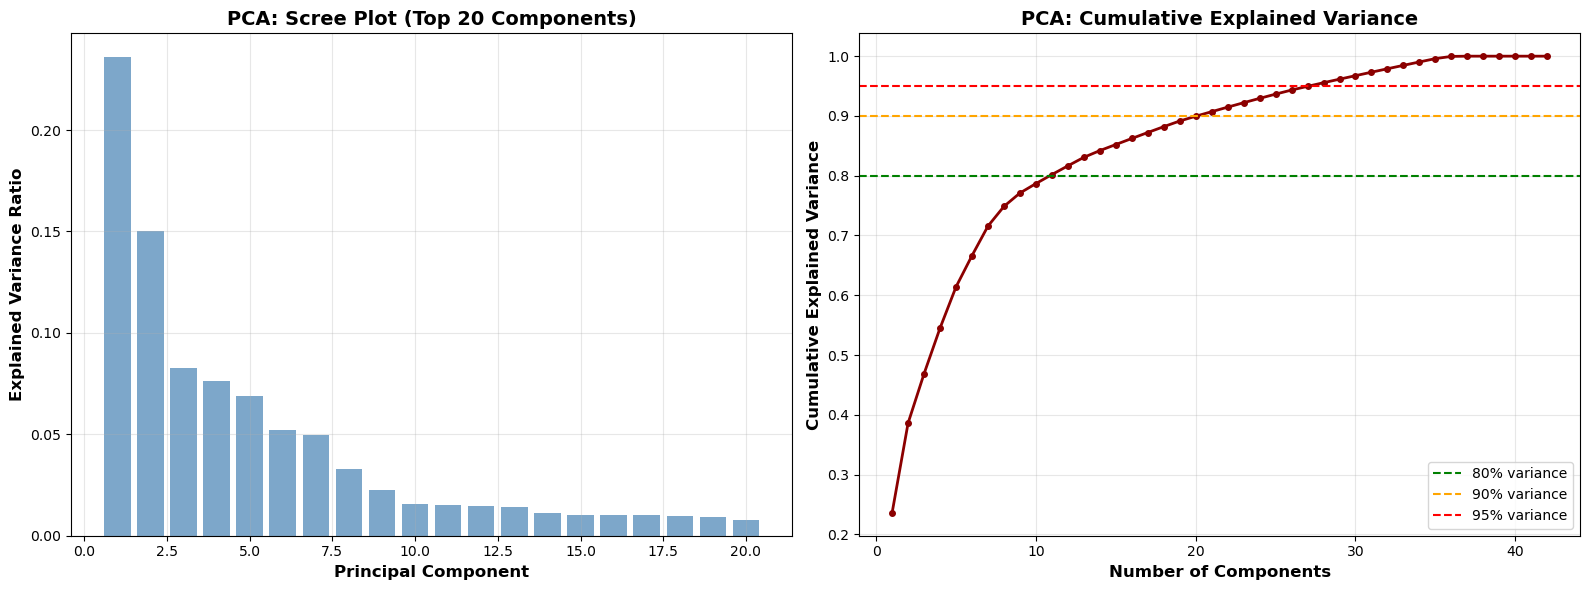

✅ Saved: pca_variance_analysis.png


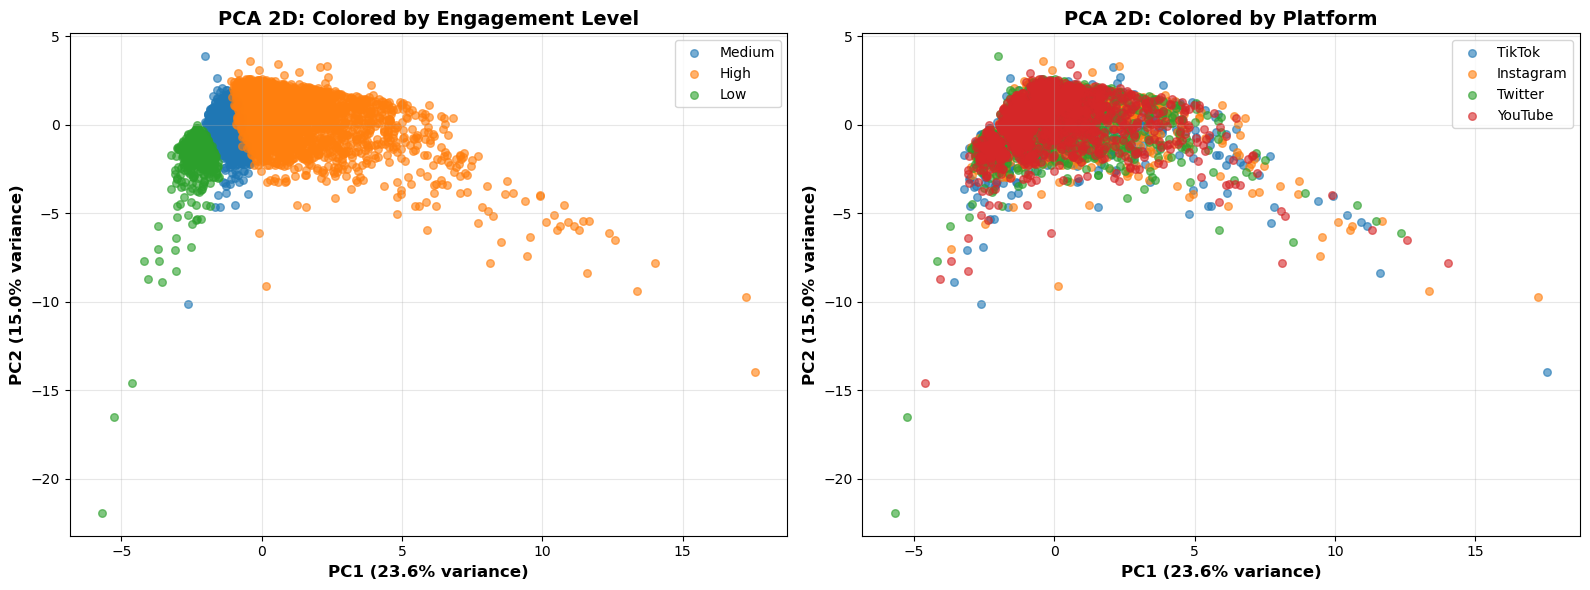

✅ Saved: pca_2d_scatter.png


In [5]:
# Visualization 1: Scree Plot (Explained Variance)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1a: Individual explained variance
axes[0].bar(range(1, min(21, len(explained_variance)+1)), 
            explained_variance[:20], 
            alpha=0.7, color='steelblue')
axes[0].set_xlabel('Principal Component', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Explained Variance Ratio', fontsize=12, fontweight='bold')
axes[0].set_title('PCA: Scree Plot (Top 20 Components)', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Plot 1b: Cumulative explained variance
axes[1].plot(range(1, min(51, len(cumulative_variance)+1)), 
             cumulative_variance[:50], 
             marker='o', linewidth=2, markersize=4, color='darkred')
axes[1].axhline(y=0.80, color='green', linestyle='--', label='80% variance')
axes[1].axhline(y=0.90, color='orange', linestyle='--', label='90% variance')
axes[1].axhline(y=0.95, color='red', linestyle='--', label='95% variance')
axes[1].set_xlabel('Number of Components', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=12, fontweight='bold')
axes[1].set_title('PCA: Cumulative Explained Variance', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pca_variance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: pca_variance_analysis.png")

# Visualization 2: PCA 2D Scatter (colored by Engagement_Level)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 2a: Colored by Engagement_Level
for level in metadata[TARGET_COL].unique():
    mask = metadata[TARGET_COL] == level
    axes[0].scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                    label=level, alpha=0.6, s=30)
axes[0].set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance)', 
                   fontsize=12, fontweight='bold')
axes[0].set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance)', 
                   fontsize=12, fontweight='bold')
axes[0].set_title('PCA 2D: Colored by Engagement Level', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot 2b: Colored by Platform
for platform in metadata['Platform'].unique():
    mask = metadata['Platform'] == platform
    axes[1].scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1], 
                    label=platform, alpha=0.6, s=30)
axes[1].set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance)', 
                   fontsize=12, fontweight='bold')
axes[1].set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance)', 
                   fontsize=12, fontweight='bold')
axes[1].set_title('PCA 2D: Colored by Platform', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'pca_2d_scatter.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: pca_2d_scatter.png")

## t-SNE (t-Distributed Stochastic Neighbor Embedding)

In [6]:
print("\n" + "-"*70)
print("1.2 t-SNE - Non-linear Dimensionality Reduction")
print("-"*70)

# t-SNE is computationally expensive - sample if dataset is very large
if len(df_ul) > 10000:
    print(f"⚠️  Large dataset ({len(df_ul)} samples) - sampling 10,000 for t-SNE")
    sample_indices = np.random.choice(len(df_ul), 10000, replace=False)
    X_tsne_input = df_ul[sample_indices]
    metadata_tsne = metadata.iloc[sample_indices]
else:
    X_tsne_input = df_ul
    metadata_tsne = metadata

print(f"\nRunning t-SNE with different perplexity values...")
print(f"*"*60)

# Try different perplexity values
perplexities = [5, 30, 50]
tsne_results = {}

for perplexity in perplexities:
    print(f"\n   Training t-SNE with perplexity={perplexity}...")
    
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        random_state=RANDOM_STATE,
        max_iter=1000,
        verbose=0
    )
    
    X_tsne = tsne.fit_transform(X_tsne_input)
    tsne_results[perplexity] = X_tsne
    
    print(f"   ✅ Complete: shape={X_tsne.shape}")


----------------------------------------------------------------------
1.2 t-SNE - Non-linear Dimensionality Reduction
----------------------------------------------------------------------

Running t-SNE with different perplexity values...
************************************************************

   Training t-SNE with perplexity=5...
   ✅ Complete: shape=(4730, 2)

   Training t-SNE with perplexity=30...
   ✅ Complete: shape=(4730, 2)

   Training t-SNE with perplexity=50...
   ✅ Complete: shape=(4730, 2)


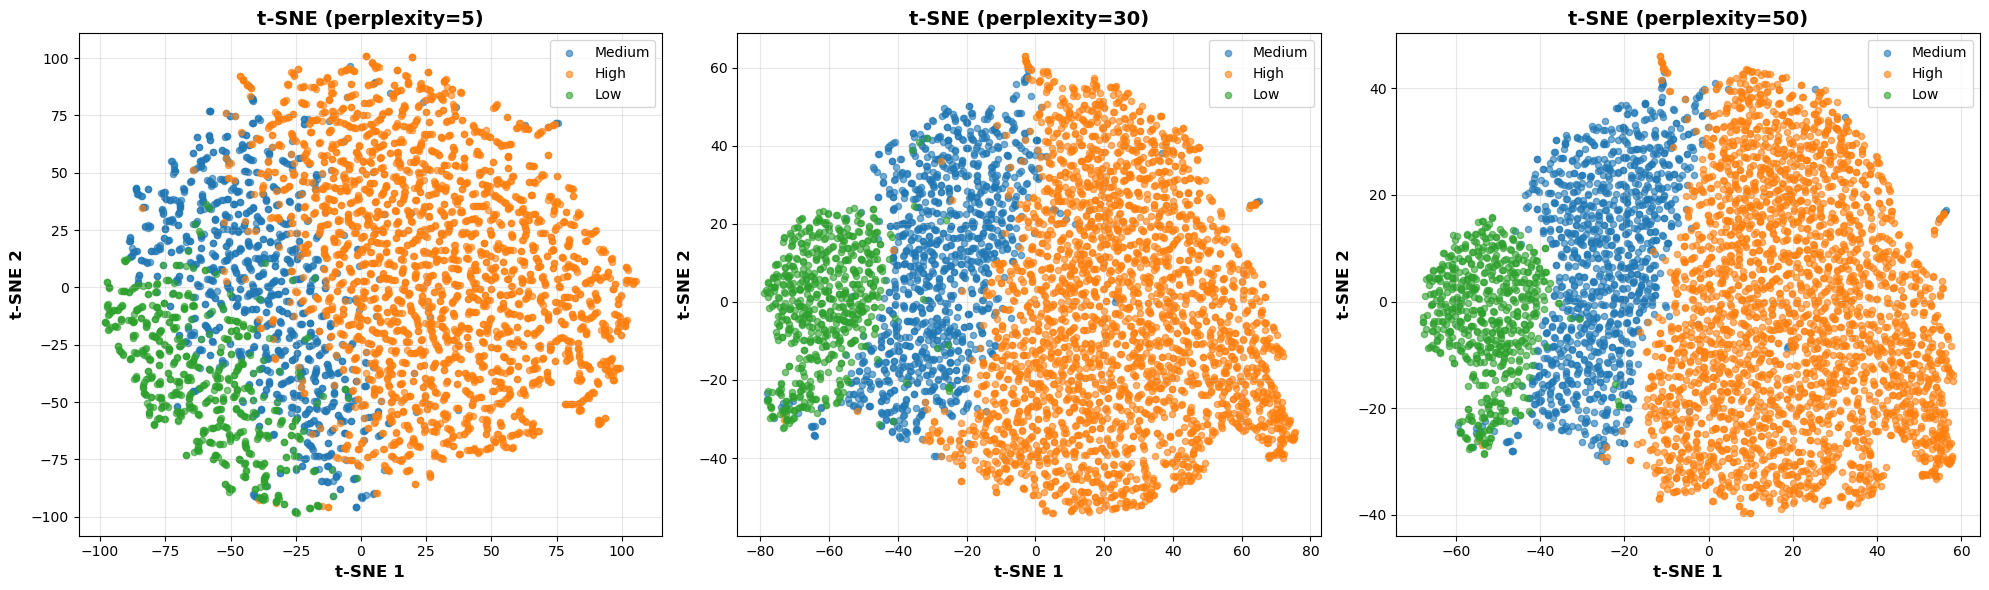

✅ Saved: tsne_perplexity_comparison.png


In [7]:
# Visualization 3: t-SNE with different perplexities
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (perplexity, X_tsne) in enumerate(tsne_results.items()):
    # Color by Engagement_Level
    for level in metadata_tsne[TARGET_COL].unique():
        mask = metadata_tsne[TARGET_COL].values == level
        axes[idx].scatter(X_tsne[mask, 0], X_tsne[mask, 1],
                         label=level, alpha=0.6, s=20)
    
    axes[idx].set_xlabel('t-SNE 1', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('t-SNE 2', fontsize=12, fontweight='bold')
    axes[idx].set_title(f't-SNE (perplexity={perplexity})', fontsize=14, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'tsne_perplexity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: tsne_perplexity_comparison.png")

# Use perplexity=30 for subsequent analysis (standard choice)
X_tsne_2d = tsne_results[30]

## UMAP (Uniform Manifold Approximation and Projection)


----------------------------------------------------------------------
1.3 UMAP - Non-linear Dimensionality Reduction
----------------------------------------------------------------------

Running UMAP with different n_neighbors values...

   Training UMAP with n_neighbors=5...
   ✅ Complete: shape=(4730, 2)

   Training UMAP with n_neighbors=15...
   ✅ Complete: shape=(4730, 2)

   Training UMAP with n_neighbors=30...
   ✅ Complete: shape=(4730, 2)

   Training UMAP with n_neighbors=50...
   ✅ Complete: shape=(4730, 2)

   Training UMAP 3D (n_neighbors=15)...
   ✅ Complete: shape=(4730, 3)


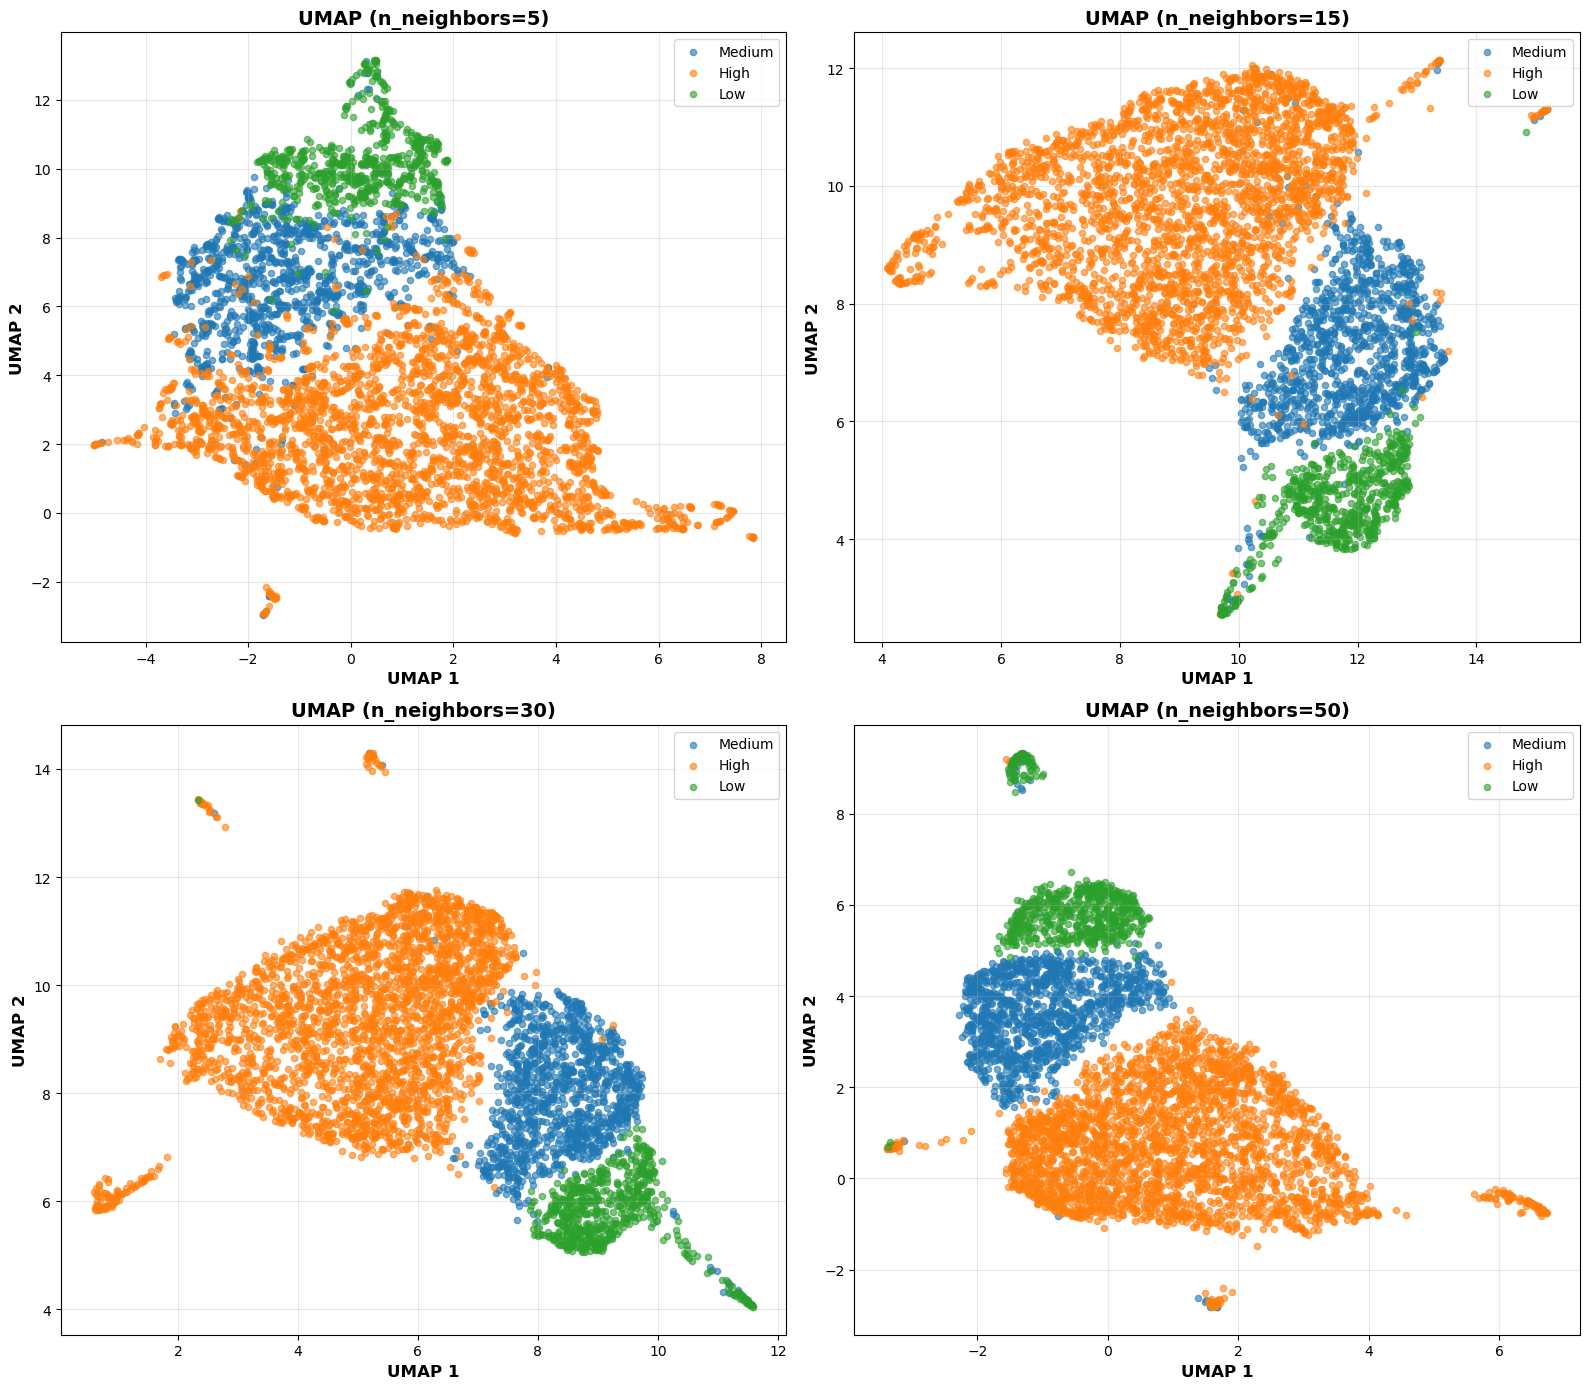

✅ Saved: umap_neighbors_comparison.png


In [8]:
print("\n" + "-"*70)
print("1.3 UMAP - Non-linear Dimensionality Reduction")
print("-"*70)

print(f"\nRunning UMAP with different n_neighbors values...")

# Try different n_neighbors values
n_neighbors_values = [5, 15, 30, 50]
umap_results = {}

for n_neighbors in n_neighbors_values:
    print(f"\n   Training UMAP with n_neighbors={n_neighbors}...")
    
    umap_model = UMAP(
        n_components=2,
        n_neighbors=n_neighbors,
        min_dist=0.1,
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    
    X_umap = umap_model.fit_transform(df_ul)
    umap_results[n_neighbors] = X_umap
    
    print(f"   ✅ Complete: shape={X_umap.shape}")
    
# 3D UMAP for visualization
print(f"\n   Training UMAP 3D (n_neighbors=15)...")
umap_3d = UMAP(n_components=3, n_neighbors=15, min_dist=0.1, 
               random_state=RANDOM_STATE, n_jobs=-1)
X_umap_3d = umap_3d.fit_transform(df_ul)
print(f"   ✅ Complete: shape={X_umap_3d.shape}")

# Visualization 4: UMAP with different n_neighbors
fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

for idx, (n_neighbors, X_umap) in enumerate(umap_results.items()):
    # Color by Engagement_Level
    for level in metadata[TARGET_COL].unique():
        mask = metadata[TARGET_COL] == level
        axes[idx].scatter(X_umap[mask, 0], X_umap[mask, 1],
                         label=level, alpha=0.6, s=20)
    
    axes[idx].set_xlabel('UMAP 1', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('UMAP 2', fontsize=12, fontweight='bold')
    axes[idx].set_title(f'UMAP (n_neighbors={n_neighbors})', fontsize=14, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'umap_neighbors_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: umap_neighbors_comparison.png")
    
X_umap_2d = umap_results[15]

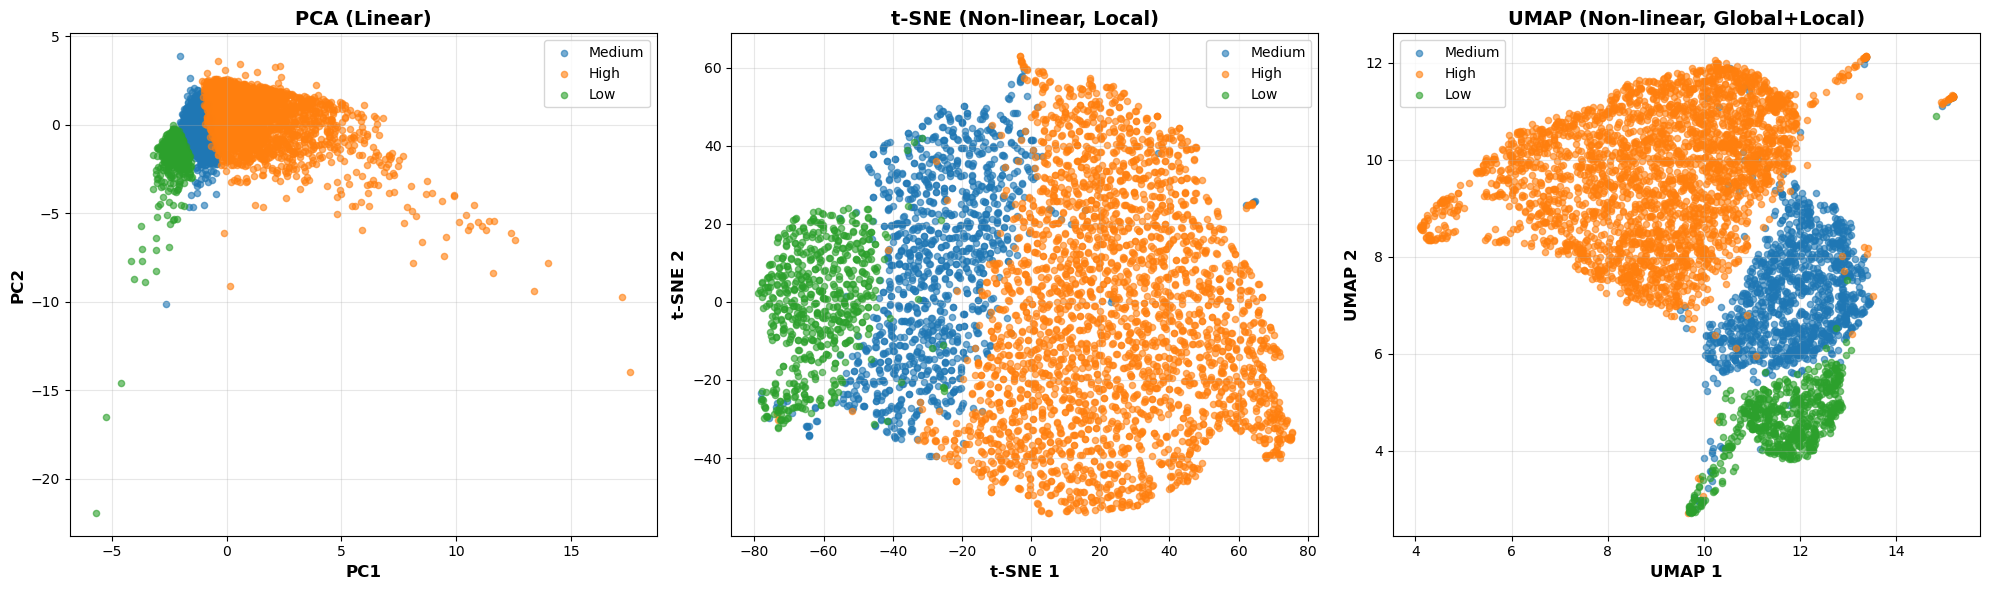

✅ Saved: dimensionality_reduction_comparison.png


In [9]:
# Visualization 5: Compare PCA vs t-SNE vs UMAP
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# PCA
for level in metadata[TARGET_COL].unique():
    mask = metadata[TARGET_COL] == level
    axes[0].scatter(X_pca_2d[mask, 0], X_pca_2d[mask, 1],
                   label=level, alpha=0.6, s=20)
axes[0].set_xlabel('PC1', fontsize=12, fontweight='bold')
axes[0].set_ylabel('PC2', fontsize=12, fontweight='bold')
axes[0].set_title('PCA (Linear)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# t-SNE (on sampled data if applicable)
for level in metadata_tsne[TARGET_COL].unique():
    mask = metadata_tsne[TARGET_COL].values == level
    axes[1].scatter(X_tsne_2d[mask, 0], X_tsne_2d[mask, 1],
                   label=level, alpha=0.6, s=20)
axes[1].set_xlabel('t-SNE 1', fontsize=12, fontweight='bold')
axes[1].set_ylabel('t-SNE 2', fontsize=12, fontweight='bold')
axes[1].set_title('t-SNE (Non-linear, Local)', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

# UMAP
for level in metadata[TARGET_COL].unique():
    mask = metadata[TARGET_COL] == level
    axes[2].scatter(X_umap_2d[mask, 0], X_umap_2d[mask, 1],
                   label=level, alpha=0.6, s=20)
axes[2].set_xlabel('UMAP 1', fontsize=12, fontweight='bold')
axes[2].set_ylabel('UMAP 2', fontsize=12, fontweight='bold')
axes[2].set_title('UMAP (Non-linear, Global+Local)', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'dimensionality_reduction_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: dimensionality_reduction_comparison.png")

# Clustering

## K-Means Clustering


----------------------------------------------------------------------
2.1 KMeans - Partition-based Clustering
----------------------------------------------------------------------

Finding optimal K using Elbow Method and Silhouette Score...
   Testing K=2... Silhouette=0.243
   Testing K=3... Silhouette=0.152
   Testing K=4... Silhouette=0.153
   Testing K=5... Silhouette=0.150
   Testing K=6... Silhouette=0.149
   Testing K=7... Silhouette=0.116
   Testing K=8... Silhouette=0.112
   Testing K=9... Silhouette=0.114
   Testing K=10... Silhouette=0.116


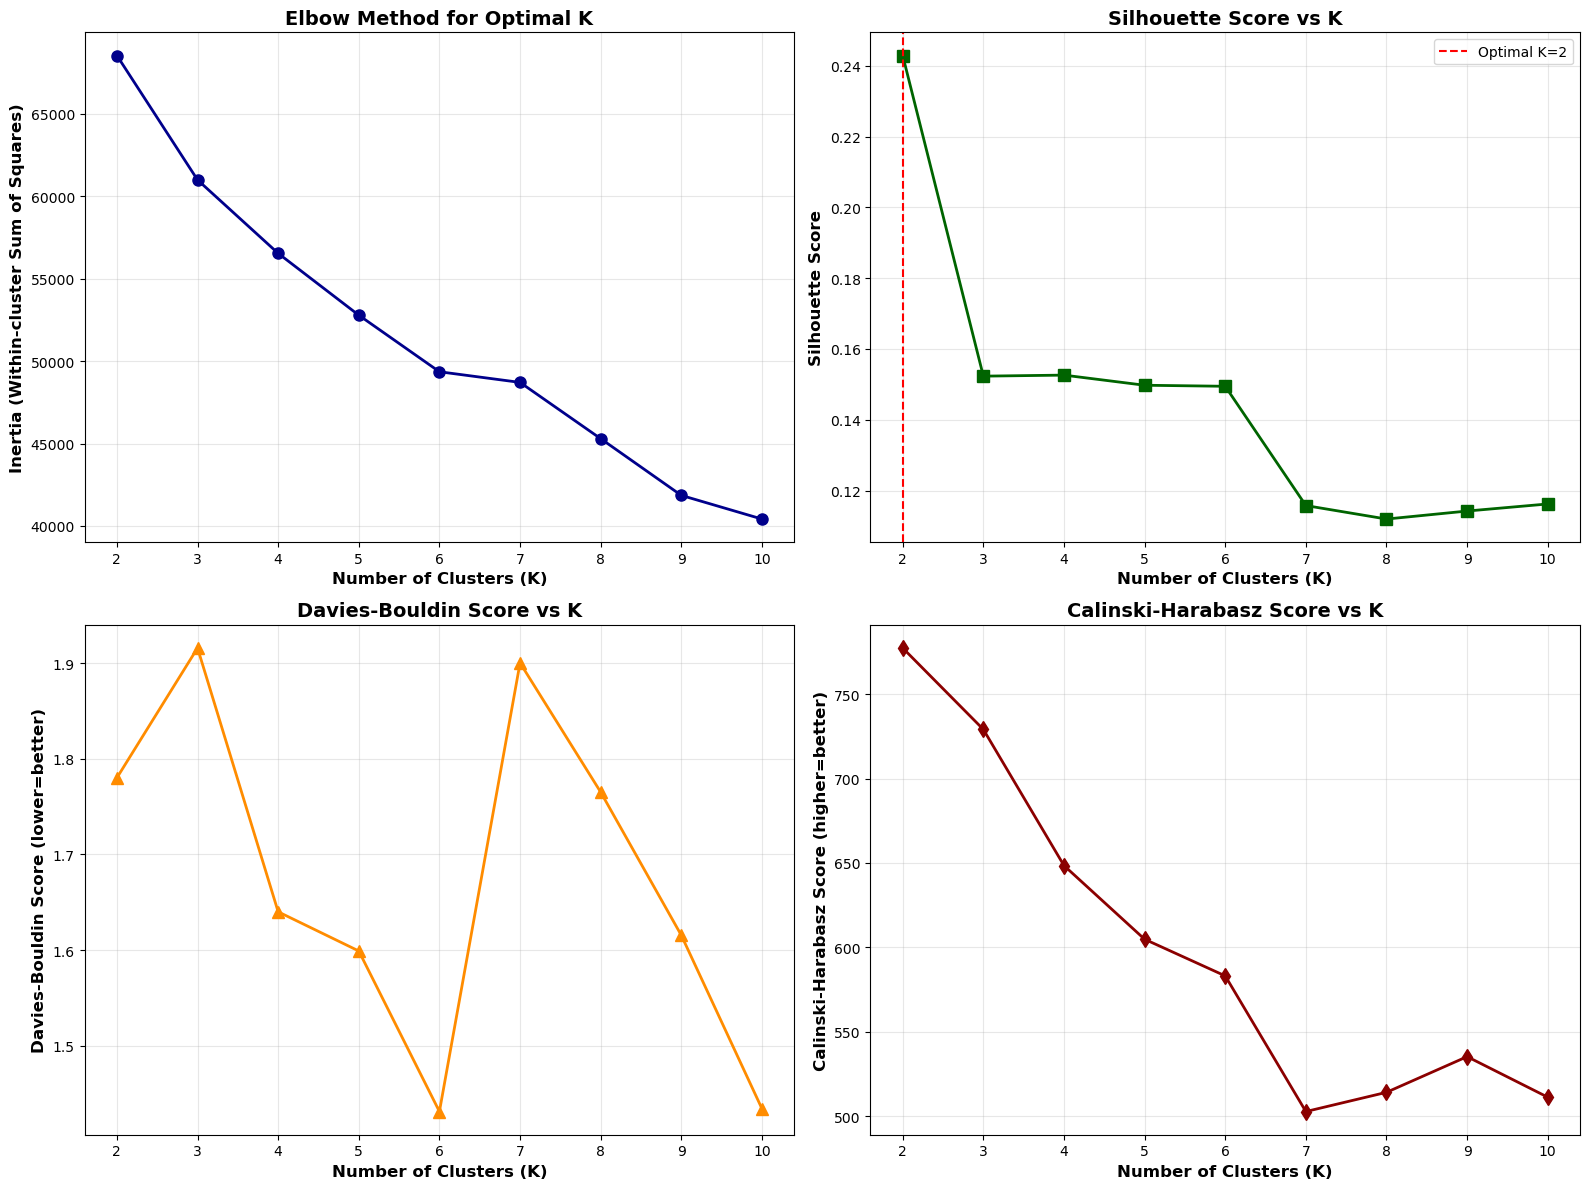

✅ Saved: kmeans_optimal_k_analysis.png

📊 Optimal K Analysis:
   Best Silhouette Score: K=2 (score=0.243)
   Best Davies-Bouldin: K=6 (score=1.431)
   Best Calinski-Harabasz: K=2 (score=777)

✅ Selected optimal K = 2

Fitting final KMeans with K=2...
✅ KMeans clustering complete
   Cluster sizes: [3802  928]


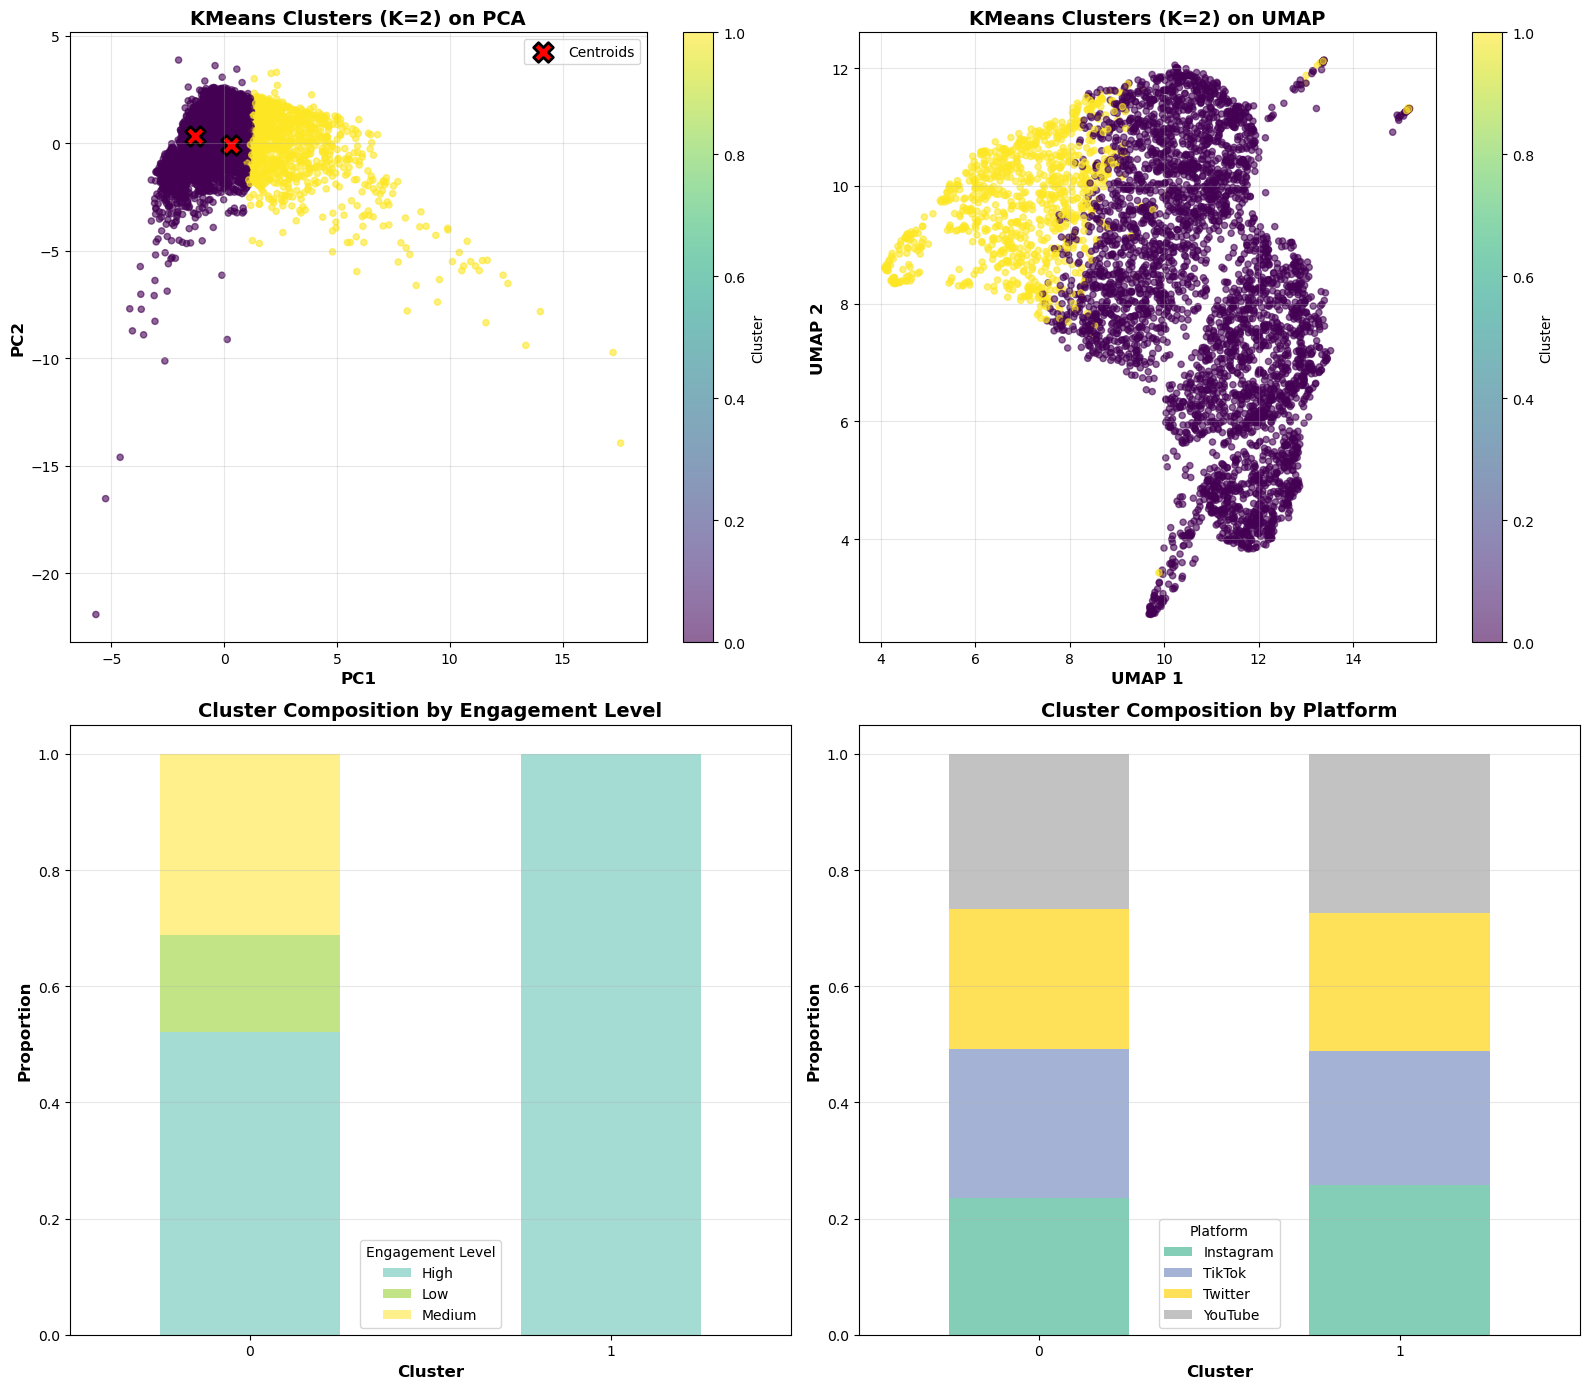

✅ Saved: kmeans_clustering_analysis.png


In [10]:
print("\n" + "-"*70)
print("2.1 KMeans - Partition-based Clustering")
print("-"*70)

# Determine optimal number of clusters using Elbow Method and Silhouette Score
print("\nFinding optimal K using Elbow Method and Silhouette Score...")

k_range = range(2, 11)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

for k in k_range:
    print(f"   Testing K={k}...", end=' ')
    
    # Fit KMeans
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    labels = kmeans.fit_predict(df_ul)
    
    # Calculate metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_ul, labels))
    davies_bouldin_scores.append(davies_bouldin_score(df_ul, labels))
    calinski_harabasz_scores.append(calinski_harabasz_score(df_ul, labels))
    
    print(f"Silhouette={silhouette_scores[-1]:.3f}")

# Visualization 6: Elbow Method and Silhouette Score
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 6a: Elbow Method (Inertia)
axes[0, 0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='darkblue')
axes[0, 0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Inertia (Within-cluster Sum of Squares)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
axes[0, 0].grid(alpha=0.3)

# Plot 6b: Silhouette Score
axes[0, 1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='darkgreen')
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
axes[0, 1].axvline(x=optimal_k_silhouette, color='red', linestyle='--', 
                   label=f'Optimal K={optimal_k_silhouette}')
axes[0, 1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Silhouette Score vs K', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Plot 6c: Davies-Bouldin Score (lower is better)
axes[1, 0].plot(k_range, davies_bouldin_scores, marker='^', linewidth=2, markersize=8, color='darkorange')
axes[1, 0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Davies-Bouldin Score (lower=better)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Davies-Bouldin Score vs K', fontsize=14, fontweight='bold')
axes[1, 0].grid(alpha=0.3)

# Plot 6d: Calinski-Harabasz Score (higher is better)
axes[1, 1].plot(k_range, calinski_harabasz_scores, marker='d', linewidth=2, markersize=8, color='darkred')
axes[1, 1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Calinski-Harabasz Score (higher=better)', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Calinski-Harabasz Score vs K', fontsize=14, fontweight='bold')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'kmeans_optimal_k_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: kmeans_optimal_k_analysis.png")

# Choose optimal K
print(f"\n📊 Optimal K Analysis:")
print(f"   Best Silhouette Score: K={optimal_k_silhouette} (score={max(silhouette_scores):.3f})")
print(f"   Best Davies-Bouldin: K={k_range[np.argmin(davies_bouldin_scores)]} (score={min(davies_bouldin_scores):.3f})")
print(f"   Best Calinski-Harabasz: K={k_range[np.argmax(calinski_harabasz_scores)]} (score={max(calinski_harabasz_scores):.0f})")

# Use the K with best silhouette score
optimal_k = optimal_k_silhouette
print(f"\n✅ Selected optimal K = {optimal_k}")

# Fit final KMeans model
print(f"\nFitting final KMeans with K={optimal_k}...")
kmeans_final = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=20)
kmeans_labels = kmeans_final.fit_predict(df_ul)

print(f"✅ KMeans clustering complete")
print(f"   Cluster sizes: {np.bincount(kmeans_labels)}")

# Visualization 7: KMeans Clusters in Reduced Spaces
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 7a: KMeans on PCA
scatter = axes[0, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                             c=kmeans_labels, cmap='viridis', 
                             alpha=0.6, s=20)
axes[0, 0].scatter(kmeans_final.cluster_centers_[:, :2][:, 0], 
                   kmeans_final.cluster_centers_[:, :2][:, 1],
                   c='red', marker='X', s=200, edgecolors='black', linewidths=2,
                   label='Centroids')
axes[0, 0].set_xlabel('PC1', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('PC2', fontsize=12, fontweight='bold')
axes[0, 0].set_title(f'KMeans Clusters (K={optimal_k}) on PCA', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 0], label='Cluster')

# Plot 7b: KMeans on UMAP
scatter = axes[0, 1].scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], 
                             c=kmeans_labels, cmap='viridis', 
                             alpha=0.6, s=20)
axes[0, 1].set_xlabel('UMAP 1', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('UMAP 2', fontsize=12, fontweight='bold')
axes[0, 1].set_title(f'KMeans Clusters (K={optimal_k}) on UMAP', fontsize=14, fontweight='bold')
axes[0, 1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='Cluster')

# Plot 7c: Cluster distribution by Engagement_Level
cluster_engagement = pd.crosstab(kmeans_labels, metadata[TARGET_COL], normalize='index')
cluster_engagement.plot(kind='bar', stacked=True, ax=axes[1, 0], 
                       colormap='Set3', alpha=0.8)
axes[1, 0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Proportion', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Cluster Composition by Engagement Level', fontsize=14, fontweight='bold')
axes[1, 0].legend(title='Engagement Level')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)
axes[1, 0].grid(alpha=0.3, axis='y')

# Plot 7d: Cluster distribution by Platform
cluster_platform = pd.crosstab(kmeans_labels, metadata['Platform'], normalize='index')
cluster_platform.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                     colormap='Set2', alpha=0.8)
axes[1, 1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Proportion', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Cluster Composition by Platform', fontsize=14, fontweight='bold')
axes[1, 1].legend(title='Platform')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'kmeans_clustering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: kmeans_clustering_analysis.png")

## DBSCAN Clustering


----------------------------------------------------------------------
2.2 DBSCAN - Density-based Clustering
----------------------------------------------------------------------

Finding optimal eps parameter...


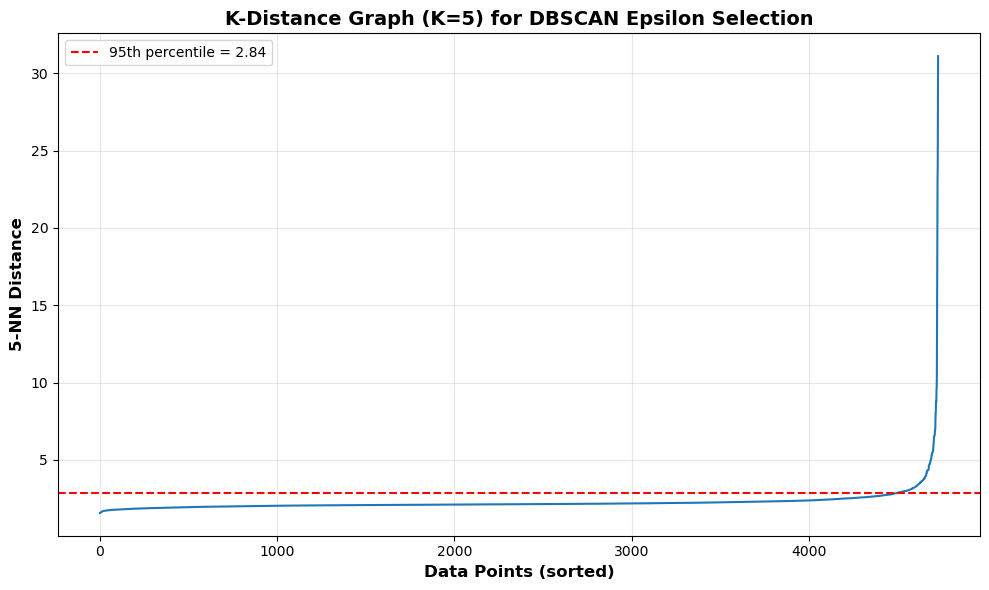

✅ Saved: dbscan_kdistance_plot.png

📊 Suggested eps from k-distance plot: 2.837

Testing different DBSCAN parameters...
   eps=0.5, min_samples=3: clusters=0, noise=4730 (100.0%), silhouette=-1.000
   eps=0.5, min_samples=5: clusters=0, noise=4730 (100.0%), silhouette=-1.000
   eps=0.5, min_samples=10: clusters=0, noise=4730 (100.0%), silhouette=-1.000
   eps=0.5, min_samples=15: clusters=0, noise=4730 (100.0%), silhouette=-1.000
   eps=1.0, min_samples=3: clusters=4, noise=4717 (99.7%), silhouette=0.754
   eps=1.0, min_samples=5: clusters=0, noise=4730 (100.0%), silhouette=-1.000
   eps=1.0, min_samples=10: clusters=0, noise=4730 (100.0%), silhouette=-1.000
   eps=1.0, min_samples=15: clusters=0, noise=4730 (100.0%), silhouette=-1.000
   eps=1.5, min_samples=3: clusters=36, noise=4607 (97.4%), silhouette=0.439
   eps=1.5, min_samples=5: clusters=0, noise=4730 (100.0%), silhouette=-1.000
   eps=1.5, min_samples=10: clusters=0, noise=4730 (100.0%), silhouette=-1.000
   eps=1.5, min_samp

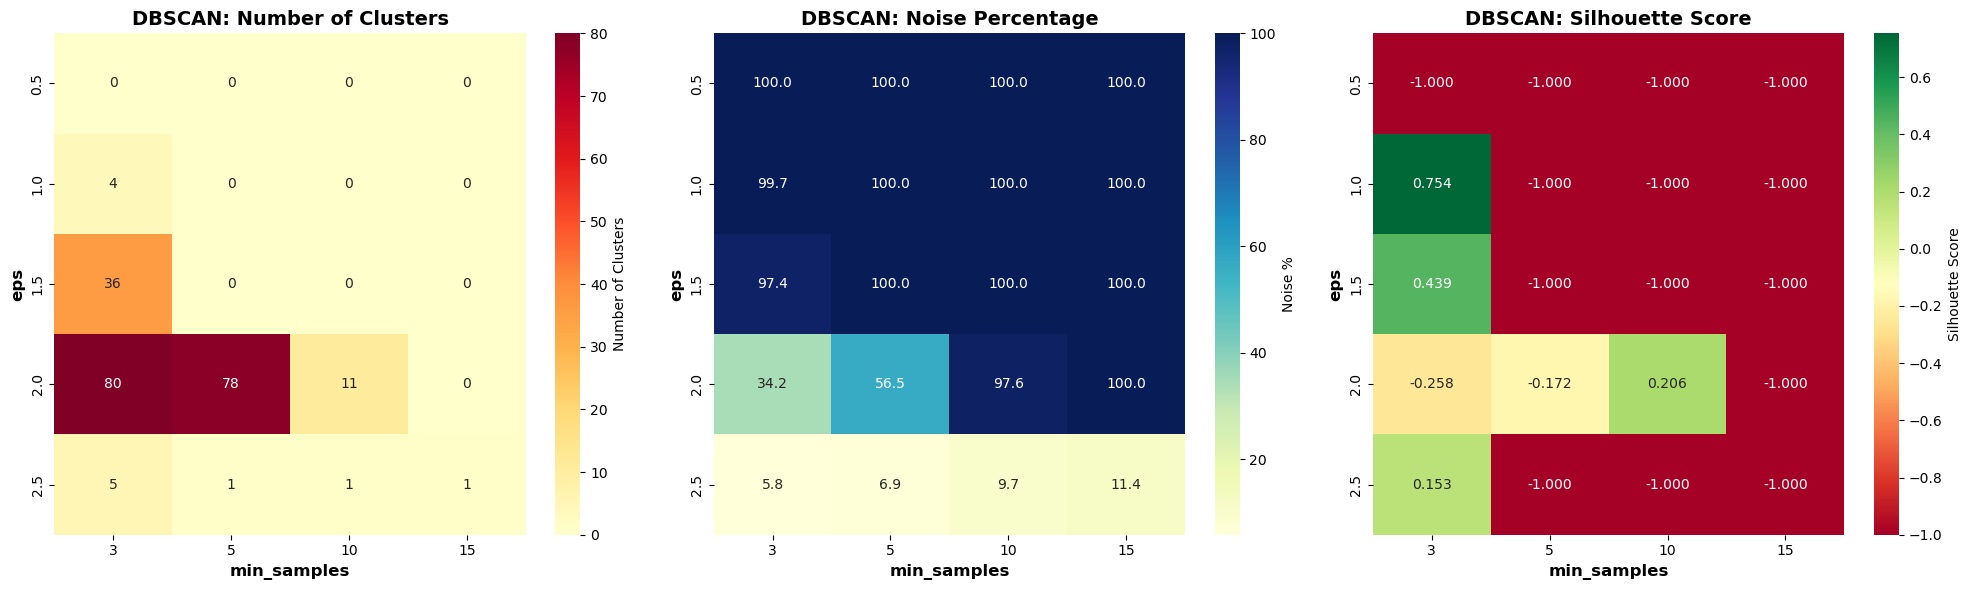

✅ Saved: dbscan_parameter_grid.png


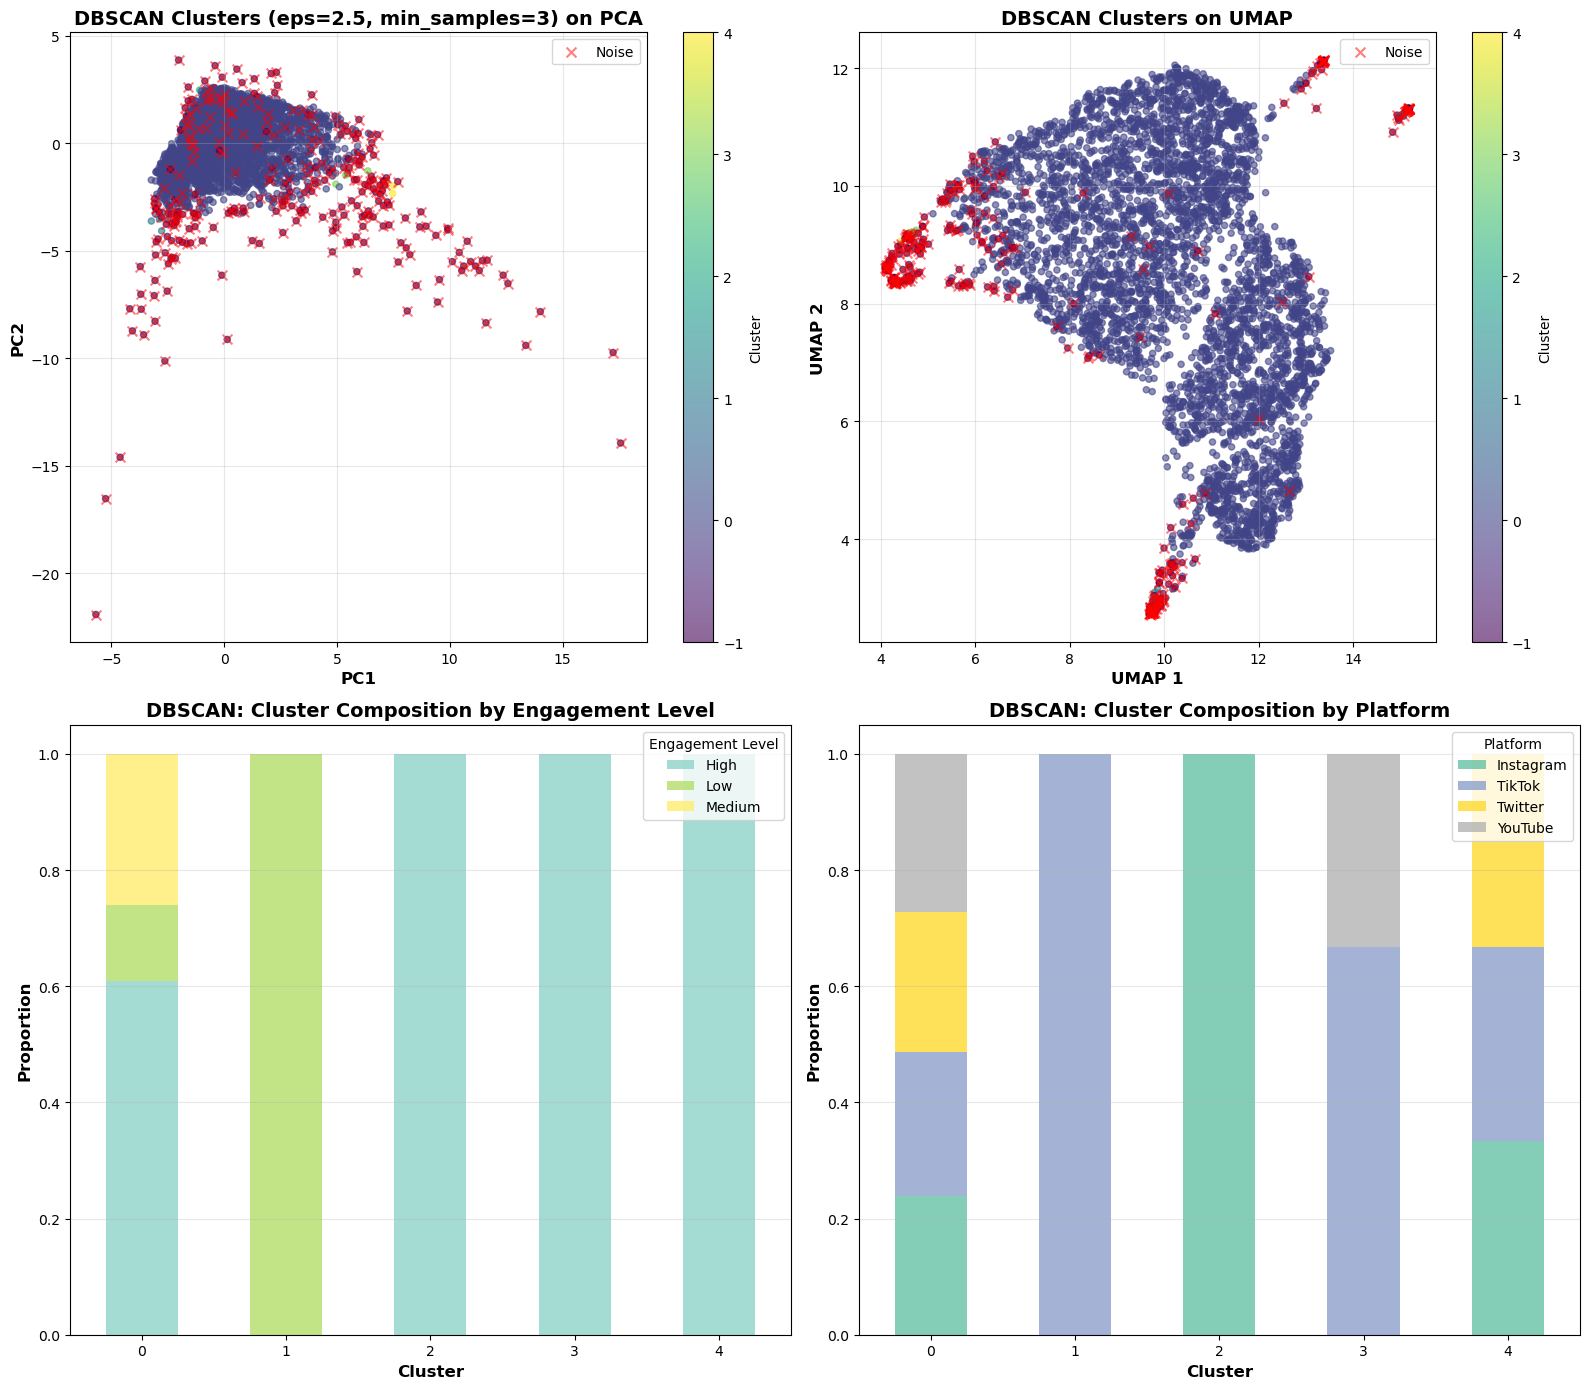

✅ Saved: dbscan_clustering_analysis.png


In [11]:
print("\n" + "-"*70)
print("2.2 DBSCAN - Density-based Clustering")
print("-"*70)

# DBSCAN requires tuning eps and min_samples
# Use heuristics to find good starting points

from sklearn.neighbors import NearestNeighbors

# Find optimal eps using k-distance plot
print("\nFinding optimal eps parameter...")

# Use k = min_samples (rule of thumb: 2 * n_features)
min_samples_default = 5  # Good starting point
k = min_samples_default

neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(df_ul)
distances, indices = neighbors_fit.kneighbors(df_ul)

# Sort and plot distances
distances = np.sort(distances[:, k-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.xlabel('Data Points (sorted)', fontsize=12, fontweight='bold')
plt.ylabel(f'{k}-NN Distance', fontsize=12, fontweight='bold')
plt.title(f'K-Distance Graph (K={k}) for DBSCAN Epsilon Selection', fontsize=14, fontweight='bold')
plt.grid(alpha=0.3)
plt.axhline(y=np.percentile(distances, 95), color='red', linestyle='--', 
            label=f'95th percentile = {np.percentile(distances, 95):.2f}')
plt.legend()
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'dbscan_kdistance_plot.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: dbscan_kdistance_plot.png")

# Suggested eps from elbow in k-distance plot
suggested_eps = np.percentile(distances, 95)
print(f"\n📊 Suggested eps from k-distance plot: {suggested_eps:.3f}")

# Try different eps and min_samples combinations
print("\nTesting different DBSCAN parameters...")

eps_values = [0.5, 1.0, 1.5, 2.0, 2.5]
min_samples_values = [3, 5, 10, 15]

dbscan_results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(df_ul)
        
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        
        # Only calculate silhouette if we have valid clusters
        if n_clusters > 1 and n_noise < len(labels) - 1:
            # Remove noise points for silhouette calculation
            mask = labels != -1
            if mask.sum() > 0:
                silhouette = silhouette_score(df_ul[mask], labels[mask])
            else:
                silhouette = -1
        else:
            silhouette = -1
        
        dbscan_results.append({
            'eps': eps,
            'min_samples': min_samples,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': (n_noise / len(labels)) * 100,
            'silhouette': silhouette
        })
        
        print(f"   eps={eps}, min_samples={min_samples}: "
              f"clusters={n_clusters}, noise={n_noise} ({n_noise/len(labels)*100:.1f}%), "
              f"silhouette={silhouette:.3f}")

# Convert to DataFrame for analysis
dbscan_results_df = pd.DataFrame(dbscan_results)

# Find best parameters (maximize clusters, minimize noise, maximize silhouette)
# Filter for reasonable results (at least 2 clusters, less than 50% noise)
valid_results = dbscan_results_df[
    (dbscan_results_df['n_clusters'] >= 2) & 
    (dbscan_results_df['noise_pct'] < 50)
]

if len(valid_results) > 0:
    best_idx = valid_results['silhouette'].idxmax()
    best_params = valid_results.loc[best_idx]
    optimal_eps = best_params['eps']
    optimal_min_samples = int(best_params['min_samples'])
else:
    # Fallback to suggested values
    optimal_eps = 1.5
    optimal_min_samples = 5

print(f"\n📊 Optimal DBSCAN Parameters:")
print(f"   eps = {optimal_eps}")
print(f"   min_samples = {optimal_min_samples}")

# Fit final DBSCAN model
print(f"\nFitting final DBSCAN with optimal parameters...")
dbscan_final = DBSCAN(eps=optimal_eps, min_samples=optimal_min_samples, n_jobs=-1)
dbscan_labels = dbscan_final.fit_predict(df_ul)

n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise_dbscan = list(dbscan_labels).count(-1)

print(f"✅ DBSCAN clustering complete")
print(f"   Number of clusters: {n_clusters_dbscan}")
print(f"   Noise points: {n_noise_dbscan} ({n_noise_dbscan/len(dbscan_labels)*100:.1f}%)")
print(f"   Cluster sizes: {dict(zip(*np.unique(dbscan_labels, return_counts=True)))}")

# Visualization 8: DBSCAN Parameter Grid
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 8a: Number of clusters vs parameters
pivot_clusters = dbscan_results_df.pivot_table(
    values='n_clusters', 
    index='eps', 
    columns='min_samples'
)
sns.heatmap(pivot_clusters, annot=True, fmt='.0f', cmap='YlOrRd', 
            ax=axes[0], cbar_kws={'label': 'Number of Clusters'})
axes[0].set_title('DBSCAN: Number of Clusters', fontsize=14, fontweight='bold')
axes[0].set_xlabel('min_samples', fontsize=12, fontweight='bold')
axes[0].set_ylabel('eps', fontsize=12, fontweight='bold')

# Plot 8b: Noise percentage vs parameters
pivot_noise = dbscan_results_df.pivot_table(
    values='noise_pct', 
    index='eps', 
    columns='min_samples'
)
sns.heatmap(pivot_noise, annot=True, fmt='.1f', cmap='YlGnBu', 
            ax=axes[1], cbar_kws={'label': 'Noise %'})
axes[1].set_title('DBSCAN: Noise Percentage', fontsize=14, fontweight='bold')
axes[1].set_xlabel('min_samples', fontsize=12, fontweight='bold')
axes[1].set_ylabel('eps', fontsize=12, fontweight='bold')

# Plot 8c: Silhouette score vs parameters
pivot_silhouette = dbscan_results_df.pivot_table(
    values='silhouette', 
    index='eps', 
    columns='min_samples'
)
sns.heatmap(pivot_silhouette, annot=True, fmt='.3f', cmap='RdYlGn', 
            ax=axes[2], cbar_kws={'label': 'Silhouette Score'})
axes[2].set_title('DBSCAN: Silhouette Score', fontsize=14, fontweight='bold')
axes[2].set_xlabel('min_samples', fontsize=12, fontweight='bold')
axes[2].set_ylabel('eps', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'dbscan_parameter_grid.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: dbscan_parameter_grid.png")

# Visualization 9: DBSCAN Clusters in Reduced Spaces
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

# Plot 9a: DBSCAN on PCA
scatter = axes[0, 0].scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], 
                             c=dbscan_labels, cmap='viridis', 
                             alpha=0.6, s=20)
# Highlight noise points
noise_mask = dbscan_labels == -1
axes[0, 0].scatter(X_pca_2d[noise_mask, 0], X_pca_2d[noise_mask, 1],
                   c='red', marker='x', s=50, alpha=0.5, label='Noise')
axes[0, 0].set_xlabel('PC1', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('PC2', fontsize=12, fontweight='bold')
axes[0, 0].set_title(f'DBSCAN Clusters (eps={optimal_eps}, min_samples={optimal_min_samples}) on PCA', 
                     fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 0], label='Cluster')

# Plot 9b: DBSCAN on UMAP
scatter = axes[0, 1].scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], 
                             c=dbscan_labels, cmap='viridis', 
                             alpha=0.6, s=20)
axes[0, 1].scatter(X_umap_2d[noise_mask, 0], X_umap_2d[noise_mask, 1],
                   c='red', marker='x', s=50, alpha=0.5, label='Noise')
axes[0, 1].set_xlabel('UMAP 1', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('UMAP 2', fontsize=12, fontweight='bold')
axes[0, 1].set_title(f'DBSCAN Clusters on UMAP', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0, 1], label='Cluster')

# Plot 9c: DBSCAN cluster distribution by Engagement_Level (exclude noise)
valid_dbscan = dbscan_labels != -1
if valid_dbscan.sum() > 0:
    cluster_engagement_db = pd.crosstab(
        dbscan_labels[valid_dbscan], 
        metadata[TARGET_COL][valid_dbscan], 
        normalize='index'
    )
    cluster_engagement_db.plot(kind='bar', stacked=True, ax=axes[1, 0], 
                              colormap='Set3', alpha=0.8)
    axes[1, 0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('Proportion', fontsize=12, fontweight='bold')
    axes[1, 0].set_title('DBSCAN: Cluster Composition by Engagement Level', 
                         fontsize=14, fontweight='bold')
    axes[1, 0].legend(title='Engagement Level')
    axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)
    axes[1, 0].grid(alpha=0.3, axis='y')

# Plot 9d: DBSCAN cluster distribution by Platform (exclude noise)
if valid_dbscan.sum() > 0:
    cluster_platform_db = pd.crosstab(
        dbscan_labels[valid_dbscan], 
        metadata['Platform'][valid_dbscan], 
        normalize='index'
    )
    cluster_platform_db.plot(kind='bar', stacked=True, ax=axes[1, 1], 
                            colormap='Set2', alpha=0.8)
    axes[1, 1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
    axes[1, 1].set_ylabel('Proportion', fontsize=12, fontweight='bold')
    axes[1, 1].set_title('DBSCAN: Cluster Composition by Platform', 
                         fontsize=14, fontweight='bold')
    axes[1, 1].legend(title='Platform')
    axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=0)
    axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'dbscan_clustering_analysis.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: dbscan_clustering_analysis.png")

## Cluster Analysis & Interpretation


PART 3: CLUSTER CHARACTERIZATION & INTERPRETATION

----------------------------------------------------------------------
3.1 KMeans Cluster Profiles
----------------------------------------------------------------------

📊 KMeans Cluster Profiles:
                     Views                             Likes            \
                      mean     median         std       mean    median   
KMeans_Cluster                                                           
0               3067185.70  3107031.0  1165656.95  234809.86  225803.5   
1                823454.41   756603.5   437599.38  296925.76  312839.5   

                             Shares                     Comments           \
                      std      mean   median       std      mean   median   
KMeans_Cluster                                                              
0               143327.80  48890.99  48515.5  28977.72  24325.78  24150.0   
1               137729.55  57018.26  59797.0  28423.80  27011.90  27733

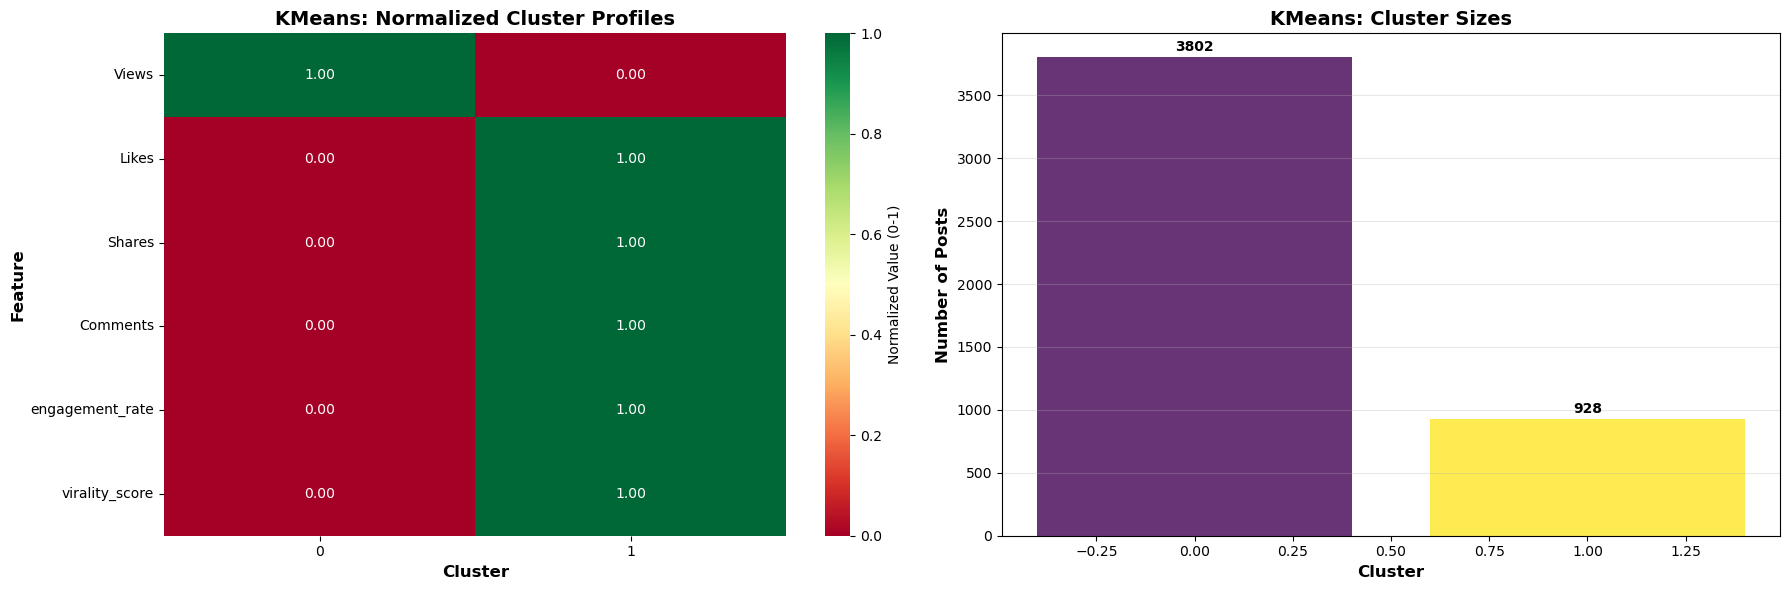

✅ Saved: kmeans_cluster_profiles.png

----------------------------------------------------------------------
3.2 DBSCAN Cluster Profiles
----------------------------------------------------------------------

📊 DBSCAN Cluster Profiles:
                     Views                             Likes            \
                      mean     median         std       mean    median   
DBSCAN_Cluster                                                           
0               2704587.25  2711504.0  1339821.21  252117.38  249097.0   
1               4289777.33  4198164.0   393446.52    5147.00    5327.0   
2               3600121.00  3442475.0  1125661.89  440002.33  429165.0   
3                335793.00   344152.0    18791.81  206607.67  207516.0   
4                271832.00   281552.0    32345.54  231371.00  246077.0   

                             Shares                     Comments           \
                      std      mean   median       std      mean   median   
DBSCAN_Cluster   

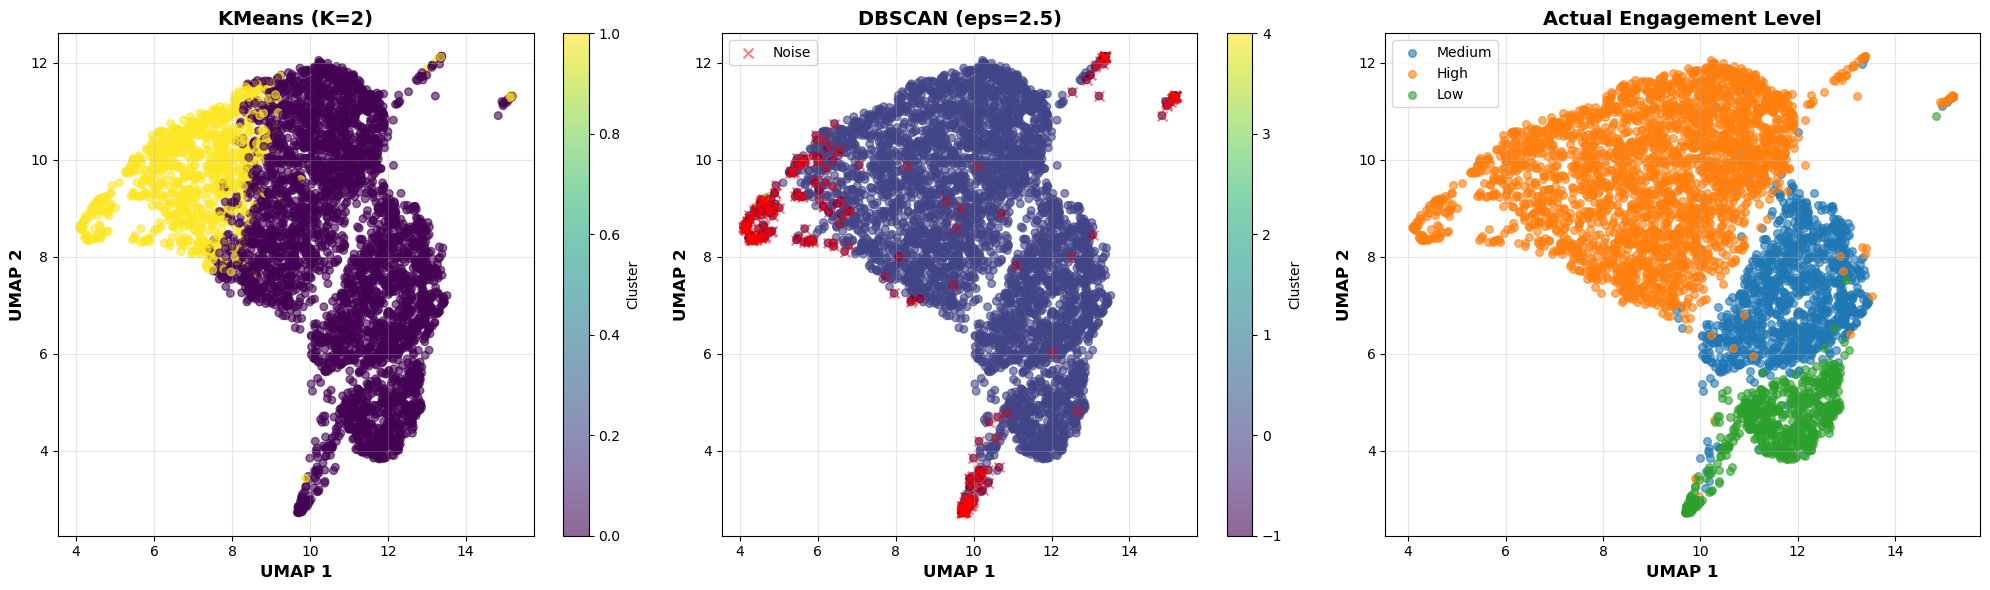

✅ Saved: clustering_comparison.png

PART 4: SAVING RESULTS
✅ Saved: data_with_clusters.csv
✅ Saved: dimensionality_reduction.npz
✅ Saved: clustering_results.npz
✅ Saved: kmeans_cluster_profiles.csv
✅ Saved: dbscan_cluster_profiles.csv

UNSUPERVISED LEARNING COMPLETE - SUMMARY

📊 DIMENSIONALITY REDUCTION:
   PCA:
      - PC1 variance: 23.59%
      - PC2 variance: 15.02%
      - Components for 90% variance: 21
   t-SNE:
      - Best perplexity: 30
      - Preserves local structure
   UMAP:
      - Best n_neighbors: 15
      - Preserves global + local structure

📊 CLUSTERING:
   KMeans:
      - Optimal K: 2
      - Silhouette Score: 0.243
      - All points assigned to clusters
   DBSCAN:
      - Optimal eps: 2.5
      - Optimal min_samples: 3
      - Clusters found: 5
      - Noise points: 273 (5.8%)

📁 FILES SAVED:
   Visualizations: 37 PNG files
   Data: data_with_clusters.csv
   Results: dimensionality_reduction.npz, clustering_results.npz
   Profiles: *_cluster_profiles.csv

✅ All un

In [ ]:
print("\n" + "="*70)
print("PART 3: CLUSTER CHARACTERIZATION & INTERPRETATION")
print("="*70)

# ========================================
# 3.1: KMeans Cluster Profiles
# ========================================

print("\n" + "-"*70)
print("3.1 KMeans Cluster Profiles")
print("-"*70)

# Add cluster labels to original dataframe
df_with_clusters = metadata_ul.copy()
df_with_clusters['KMeans_Cluster'] = kmeans_labels
df_with_clusters['DBSCAN_Cluster'] = dbscan_labels

# Calculate cluster statistics for key metrics
cluster_profiles_kmeans = df_with_clusters.groupby('KMeans_Cluster').agg({
    'Views': ['mean', 'median', 'std'],
    'Likes': ['mean', 'median', 'std'],
    'Shares': ['mean', 'median', 'std'],
    'Comments': ['mean', 'median', 'std'],
    'engagement_rate': ['mean', 'median'],
    'virality_score': ['mean', 'median'],
    TARGET_COL: lambda x: x.value_counts().index[0]  # Most common engagement level
})

print("\n📊 KMeans Cluster Profiles:")
print(cluster_profiles_kmeans.round(2))

# Cluster naming based on characteristics
print("\n🏷️  Cluster Naming & Characterization:")

for cluster_id in range(optimal_k):
    cluster_data = df_with_clusters[df_with_clusters['KMeans_Cluster'] == cluster_id]
    
    avg_views = cluster_data['Views'].mean()
    avg_engagement = cluster_data['engagement_rate'].mean()
    most_common_platform = cluster_data['Platform'].value_counts().index[0]
    most_common_engagement = cluster_data[TARGET_COL].value_counts().index[0]
    
    # TODO : Fix the engagement_level calculation
    # Determine cluster name based on characteristics
    if avg_views > metadata_ul['Views'].quantile(0.75):
        view_level = "High-Views"
    elif avg_views > metadata_ul['Views'].quantile(0.25):
        view_level = "Medium-Views"
    else:
        view_level = "Low-Views"
    
    if avg_engagement > metadata_ul['engagement_rate'].quantile(0.75):
        engagement_level = "High-Engagement"
    elif avg_engagement > metadata_ul['engagement_rate'].quantile(0.25):
        engagement_level = "Medium-Engagement"
    else:
        engagement_level = "Low-Engagement"
    
    cluster_name = f"{view_level}, {engagement_level}"
    
    print(f"\n   Cluster {cluster_id}: '{cluster_name}'")
    print(f"      Size: {len(cluster_data)} posts")
    print(f"      Avg Views: {avg_views:,.0f}")
    print(f"      Avg Engagement Rate: {avg_engagement:.3f}")
    print(f"      Dominant Platform: {most_common_platform}")
    print(f"      Dominant Engagement Level: {most_common_engagement}")

# Visualization 10: Cluster Profiles Heatmap
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot 10a: Mean values heatmap
cluster_means = df_with_clusters.groupby('KMeans_Cluster')[
    ['Views', 'Likes', 'Shares', 'Comments', 'engagement_rate', 'virality_score']
].mean()

# Normalize for better visualization
from sklearn.preprocessing import MinMaxScaler
cluster_means_normalized = pd.DataFrame(
    MinMaxScaler().fit_transform(cluster_means),
    index=cluster_means.index,
    columns=cluster_means.columns
)

sns.heatmap(cluster_means_normalized.T, annot=True, fmt='.2f', cmap='RdYlGn', 
            ax=axes[0], cbar_kws={'label': 'Normalized Value (0-1)'})
axes[0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Feature', fontsize=12, fontweight='bold')
axes[0].set_title('KMeans: Normalized Cluster Profiles', fontsize=14, fontweight='bold')

# Plot 10b: Cluster size and composition
cluster_sizes = df_with_clusters['KMeans_Cluster'].value_counts().sort_index()
colors = plt.cm.viridis(np.linspace(0, 1, len(cluster_sizes)))
axes[1].bar(cluster_sizes.index, cluster_sizes.values, color=colors, alpha=0.8)
axes[1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Posts', fontsize=12, fontweight='bold')
axes[1].set_title('KMeans: Cluster Sizes', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

for i, v in enumerate(cluster_sizes.values):
    axes[1].text(i, v + 50, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'kmeans_cluster_profiles.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: kmeans_cluster_profiles.png")

# ========================================
# 3.2: DBSCAN Cluster Profiles
# ========================================

print("\n" + "-"*70)
print("3.2 DBSCAN Cluster Profiles")
print("-"*70)

# Calculate cluster statistics (exclude noise points)
valid_dbscan_mask = df_with_clusters['DBSCAN_Cluster'] != -1

if valid_dbscan_mask.sum() > 0:
    cluster_profiles_dbscan = df_with_clusters[valid_dbscan_mask].groupby('DBSCAN_Cluster').agg({
        'Views': ['mean', 'median', 'std'],
        'Likes': ['mean', 'median', 'std'],
        'Shares': ['mean', 'median', 'std'],
        'Comments': ['mean', 'median', 'std'],
        'engagement_rate': ['mean', 'median'],
        'virality_score': ['mean', 'median'],
        TARGET_COL: lambda x: x.value_counts().index[0]
    })
    
    print("\n📊 DBSCAN Cluster Profiles:")
    print(cluster_profiles_dbscan.round(2))
    
    print("\n🏷️  DBSCAN Cluster Characterization:")
    
    for cluster_id in sorted(df_with_clusters[valid_dbscan_mask]['DBSCAN_Cluster'].unique()):
        cluster_data = df_with_clusters[df_with_clusters['DBSCAN_Cluster'] == cluster_id]
        
        print(f"\n   Cluster {cluster_id}:")
        print(f"      Size: {len(cluster_data)} posts")
        print(f"      Avg Views: {cluster_data['Views'].mean():,.0f}")
        print(f"      Avg Engagement Rate: {cluster_data['engagement_rate'].mean():.3f}")
        print(f"      Dominant Platform: {cluster_data['Platform'].value_counts().index[0]}")
    
    # Noise points analysis
    noise_data = df_with_clusters[df_with_clusters['DBSCAN_Cluster'] == -1]
    print(f"\n   Noise Points ({len(noise_data)} posts):")
    print(f"      These are outliers that don't fit any dense cluster")
    print(f"      Avg Views: {noise_data['Views'].mean():,.0f}")
    print(f"      Avg Engagement Rate: {noise_data['engagement_rate'].mean():.3f}")

# ========================================
# 3.3: Comparison: KMeans vs DBSCAN
# ========================================

print("\n" + "-"*70)
print("3.3 KMeans vs DBSCAN Comparison")
print("-"*70)

# Calculate agreement between clustering methods
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# For comparison, exclude DBSCAN noise points
comparison_mask = dbscan_labels != -1

if comparison_mask.sum() > 0:
    ari = adjusted_rand_score(kmeans_labels[comparison_mask], 
                              dbscan_labels[comparison_mask])
    nmi = normalized_mutual_info_score(kmeans_labels[comparison_mask], 
                                       dbscan_labels[comparison_mask])
    
    print(f"\n📊 Clustering Agreement Metrics:")
    print(f"   Adjusted Rand Index: {ari:.3f}")
    print(f"   Normalized Mutual Information: {nmi:.3f}")
    print(f"\n   Interpretation:")
    if ari > 0.7:
        print(f"      High agreement - Both methods find similar clusters")
    elif ari > 0.4:
        print(f"      Moderate agreement - Some similarities in cluster structure")
    else:
        print(f"      Low agreement - Methods find different cluster structures")

# Visualization 11: Side-by-side comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Plot 11a: KMeans clusters on UMAP
scatter = axes[0].scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], 
                         c=kmeans_labels, cmap='viridis', 
                         alpha=0.6, s=30)
axes[0].set_xlabel('UMAP 1', fontsize=12, fontweight='bold')
axes[0].set_ylabel('UMAP 2', fontsize=12, fontweight='bold')
axes[0].set_title(f'KMeans (K={optimal_k})', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Plot 11b: DBSCAN clusters on UMAP
scatter = axes[1].scatter(X_umap_2d[:, 0], X_umap_2d[:, 1], 
                         c=dbscan_labels, cmap='viridis', 
                         alpha=0.6, s=30)
axes[1].scatter(X_umap_2d[noise_mask, 0], X_umap_2d[noise_mask, 1],
               c='red', marker='x', s=50, alpha=0.5, label='Noise')
axes[1].set_xlabel('UMAP 1', fontsize=12, fontweight='bold')
axes[1].set_ylabel('UMAP 2', fontsize=12, fontweight='bold')
axes[1].set_title(f'DBSCAN (eps={optimal_eps})', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Cluster')

# Plot 11c: Actual Engagement_Level on UMAP
for level in metadata[TARGET_COL].unique():
    mask = metadata[TARGET_COL] == level
    axes[2].scatter(X_umap_2d[mask, 0], X_umap_2d[mask, 1],
                   label=level, alpha=0.6, s=30)
axes[2].set_xlabel('UMAP 1', fontsize=12, fontweight='bold')
axes[2].set_ylabel('UMAP 2', fontsize=12, fontweight='bold')
axes[2].set_title('Actual Engagement Level', fontsize=14, fontweight='bold')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.savefig(FIGURES_DIR / 'clustering_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print(f"✅ Saved: clustering_comparison.png")

# ========================================
# PART 4: SAVE RESULTS
# ========================================

print("\n" + "="*70)
print("PART 4: SAVING RESULTS")
print("="*70)

# Save cluster assignments
df_with_clusters.to_csv(ARTIFACTS_DIR / 'data_with_clusters.csv', index=False)
print(f"✅ Saved: data_with_clusters.csv")

# Save dimensionality reduction results
np.savez_compressed(
    ARTIFACTS_DIR / 'dimensionality_reduction.npz',
    X_pca_2d=X_pca_2d,
    X_pca_3d=X_pca_3d,
    X_tsne_2d=X_tsne_2d,
    X_umap_2d=X_umap_2d,
    X_umap_3d=X_umap_3d,
    pca_explained_variance=explained_variance,
    pca_cumulative_variance=cumulative_variance
)
print(f"✅ Saved: dimensionality_reduction.npz")

# Save clustering results
np.savez_compressed(
    ARTIFACTS_DIR / 'clustering_results.npz',
    kmeans_labels=kmeans_labels,
    kmeans_centers=kmeans_final.cluster_centers_,
    dbscan_labels=dbscan_labels,
    optimal_k=optimal_k,
    optimal_eps=optimal_eps,
    optimal_min_samples=optimal_min_samples
)
print(f"✅ Saved: clustering_results.npz")

# Save cluster profiles
cluster_profiles_kmeans.to_csv(ARTIFACTS_DIR / 'kmeans_cluster_profiles.csv')
print(f"✅ Saved: kmeans_cluster_profiles.csv")

if valid_dbscan_mask.sum() > 0:
    cluster_profiles_dbscan.to_csv(ARTIFACTS_DIR / 'dbscan_cluster_profiles.csv')
    print(f"✅ Saved: dbscan_cluster_profiles.csv")

# ========================================
# FINAL SUMMARY
# ========================================

print("\n" + "="*70)
print("UNSUPERVISED LEARNING COMPLETE - SUMMARY")
print("="*70)

print(f"\n📊 DIMENSIONALITY REDUCTION:")
print(f"   PCA:")
print(f"      - PC1 variance: {explained_variance[0]*100:.2f}%")
print(f"      - PC2 variance: {explained_variance[1]*100:.2f}%")
print(f"      - Components for 90% variance: {n_components_90}")
print(f"   t-SNE:")
print(f"      - Best perplexity: 30")
print(f"      - Preserves local structure")
print(f"   UMAP:")
print(f"      - Best n_neighbors: 15")
print(f"      - Preserves global + local structure")

print(f"\n📊 CLUSTERING:")
print(f"   KMeans:")
print(f"      - Optimal K: {optimal_k}")
print(f"      - Silhouette Score: {max(silhouette_scores):.3f}")
print(f"      - All points assigned to clusters")
print(f"   DBSCAN:")
print(f"      - Optimal eps: {optimal_eps}")
print(f"      - Optimal min_samples: {optimal_min_samples}")
print(f"      - Clusters found: {n_clusters_dbscan}")
print(f"      - Noise points: {n_noise_dbscan} ({n_noise_dbscan/len(dbscan_labels)*100:.1f}%)")

print(f"\n📁 FILES SAVED:")
print(f"   Visualizations: {len(list(FIGURES_DIR.glob('*.png')))} PNG files")
print(f"   Data: data_with_clusters.csv")
print(f"   Results: dimensionality_reduction.npz, clustering_results.npz")
print(f"   Profiles: *_cluster_profiles.csv")

print(f"\n✅ All unsupervised learning tasks complete!")
print("="*70)